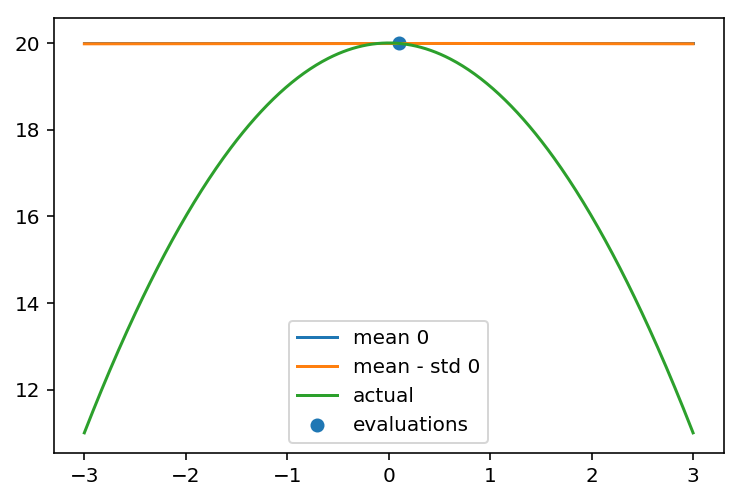

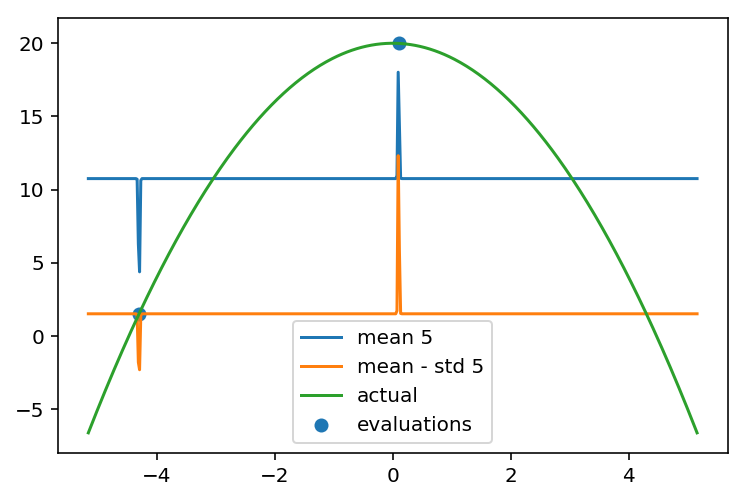

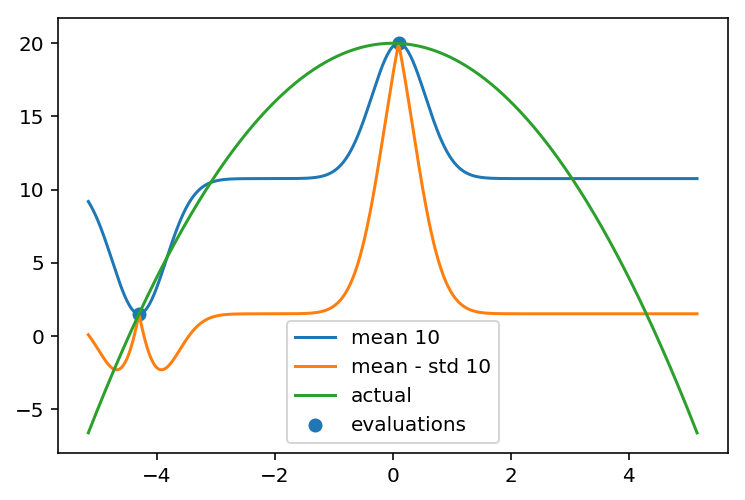

/Users/thomas/Documents/Programming/pypuffin/pypuffin/sklearn/gaussian_process.py:143: RuntimeWarning: divide by zero encountered in true_divide
  result = d_variance / (2 * std[:, numpy.newaxis])


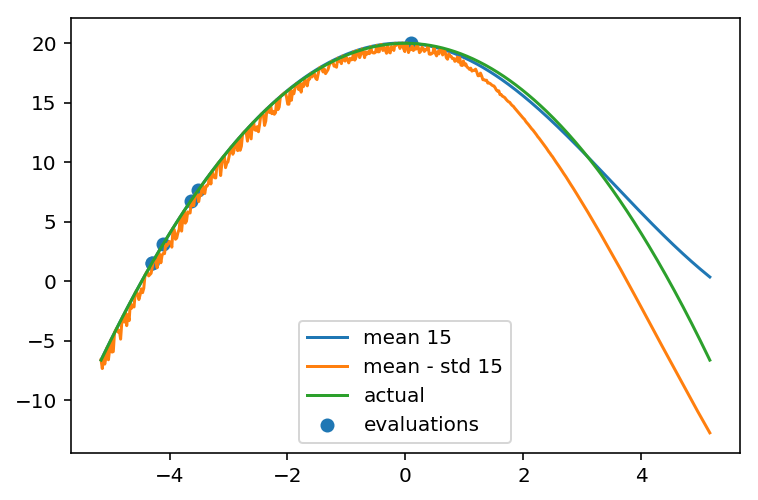

/Users/thomas/Documents/Programming/pypuffin/pypuffin/sklearn/gaussian_process.py:143: RuntimeWarning: invalid value encountered in true_divide
  result = d_variance / (2 * std[:, numpy.newaxis])


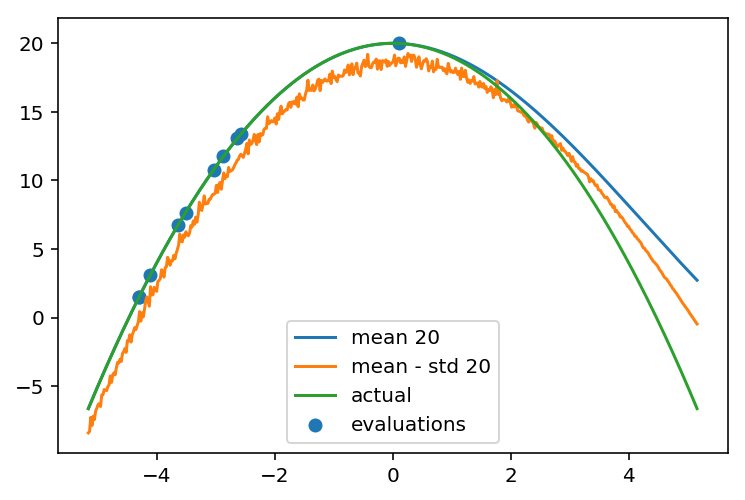

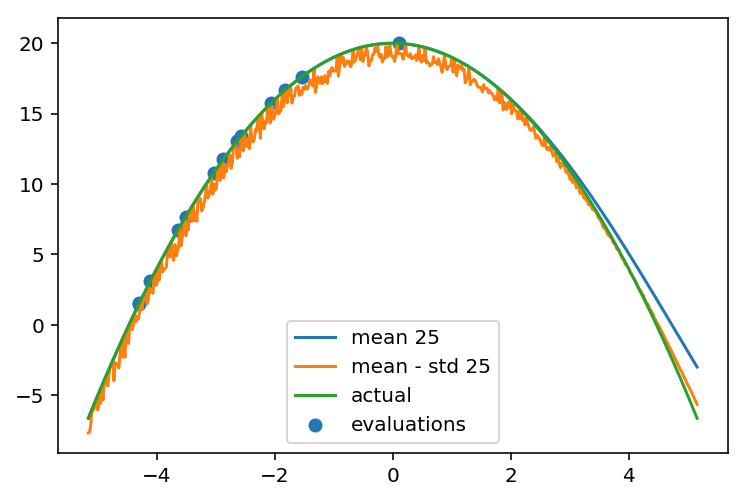

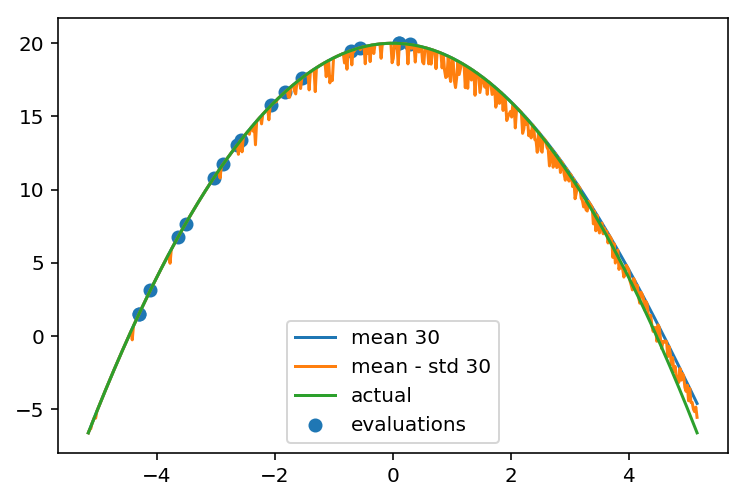

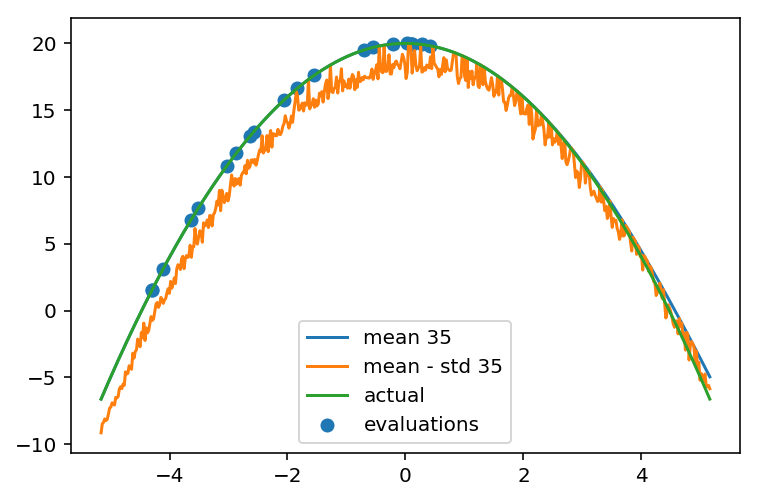

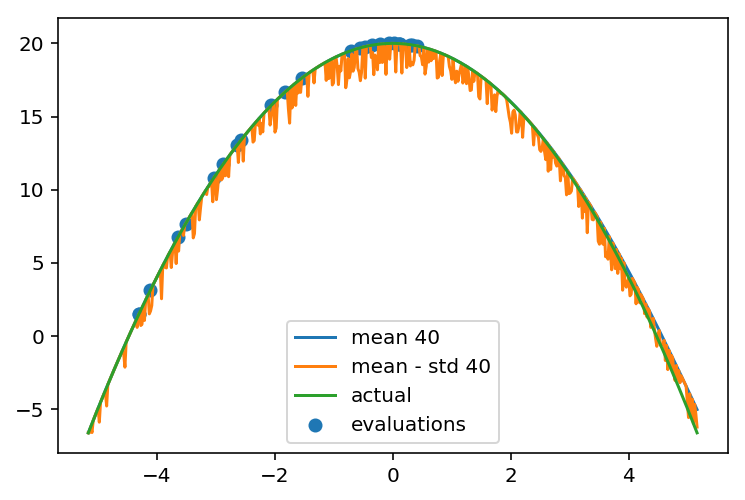

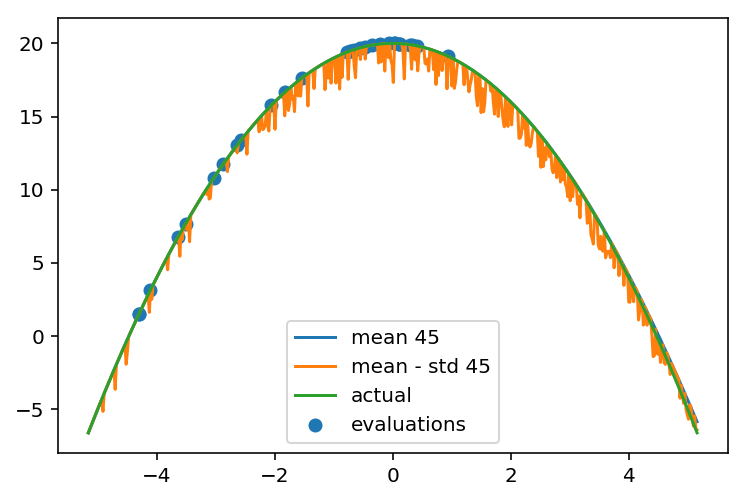

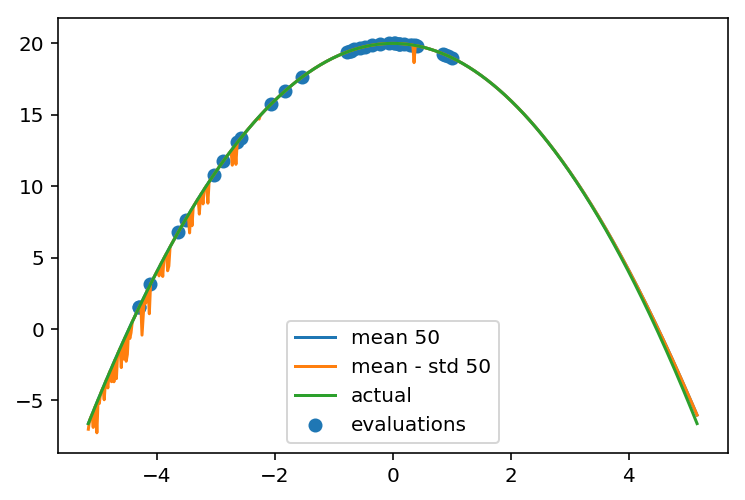

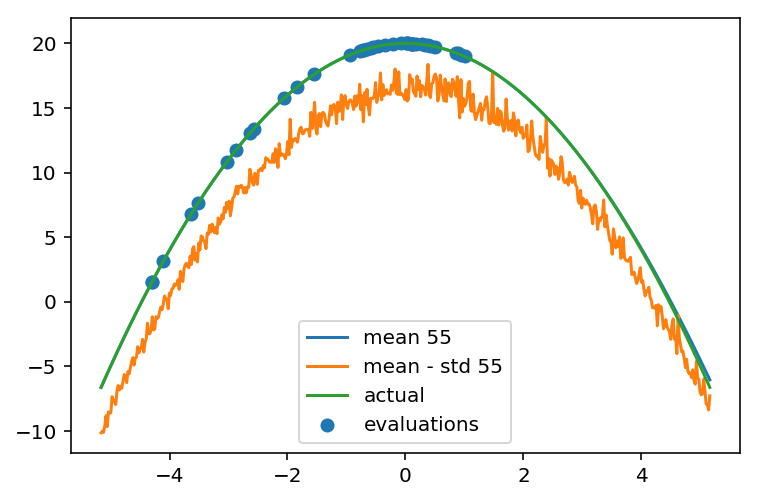

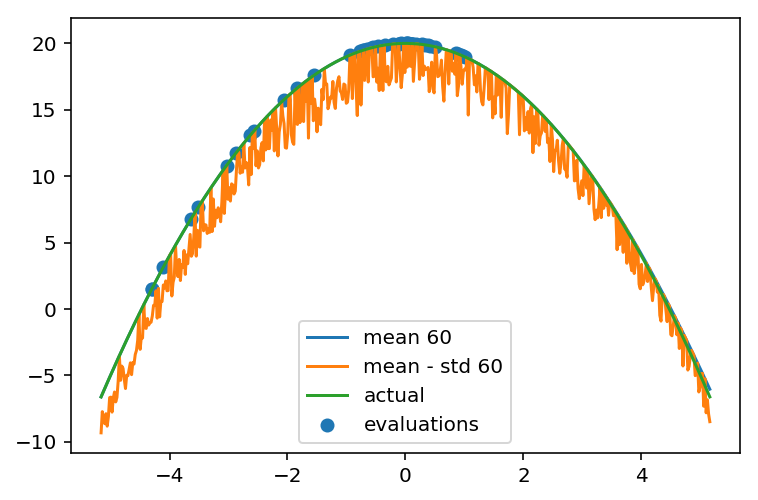

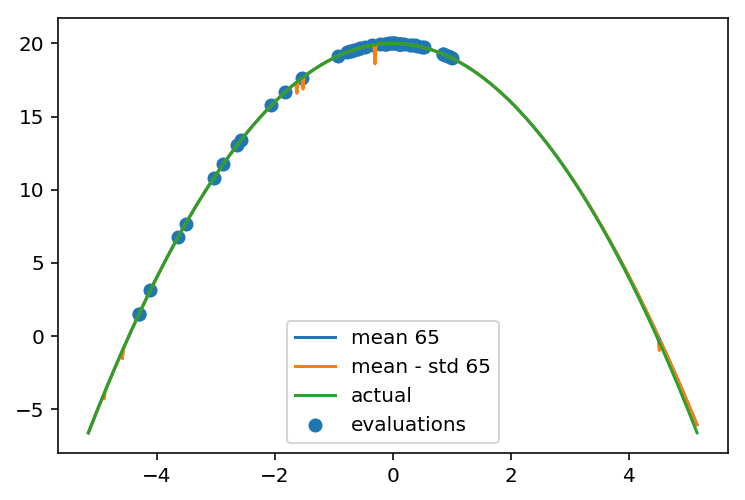

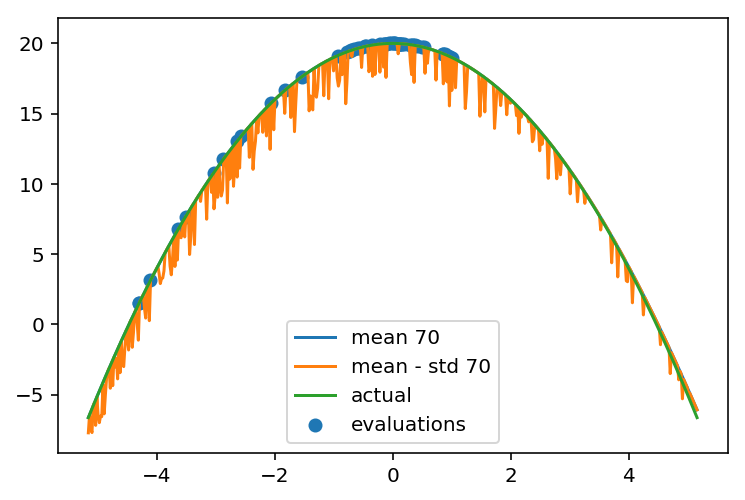

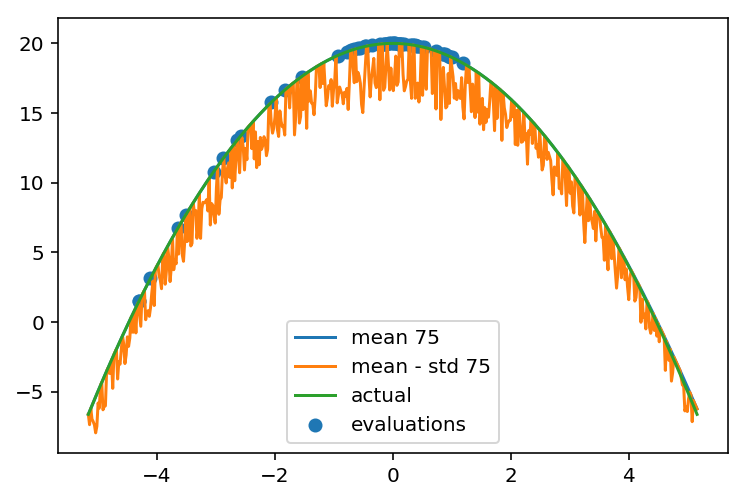

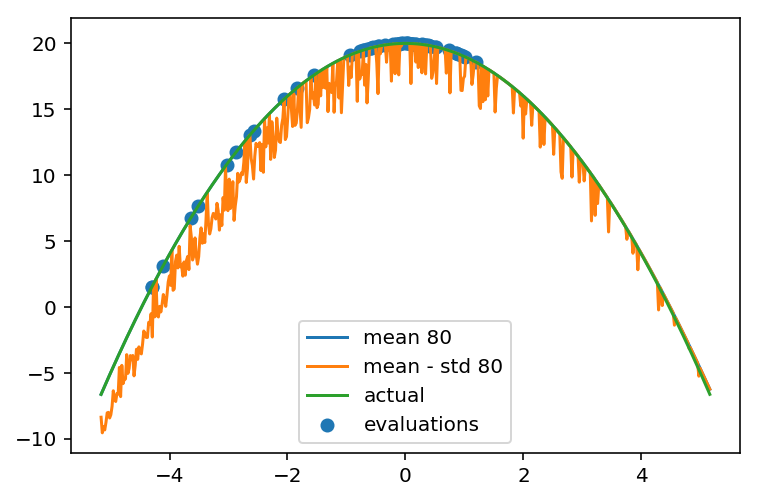

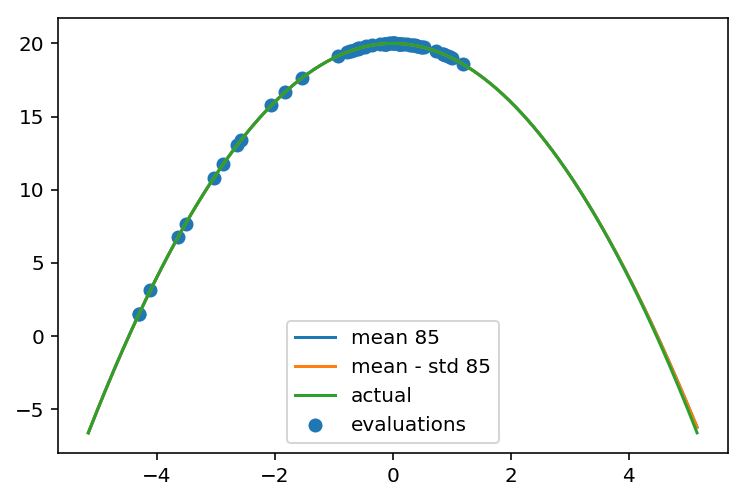

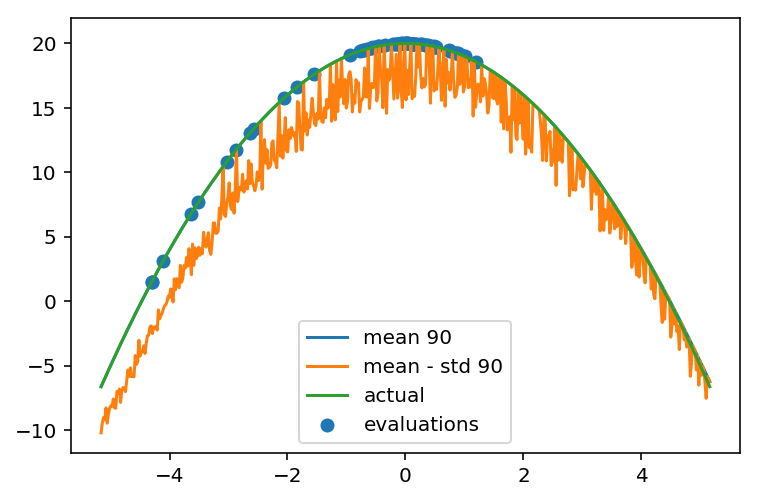

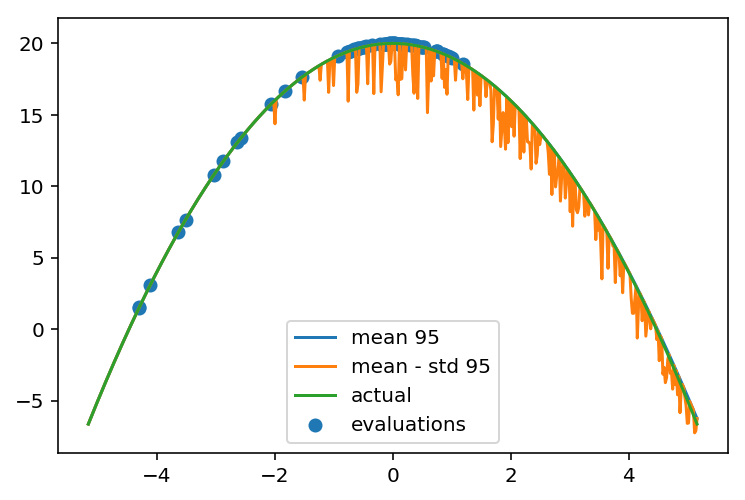

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from functools import partial

import numpy as np
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel


from pypuffin.decorators import disable_typechecking
from pypuffin.numeric.mcmc.gphmc import GPHMC
from pypuffin.numeric.mcmc.hmc import ScalarMassHMC

np.random.seed(0)

# This now has the correct arguments to be passed to GPHMC, which just wants a way
# of creating an HMC sampler given a starting point, potential function, and gradient potential
# function
f_construct_hmc = partial(ScalarMassHMC, mass=1, num_leapfrog_steps=500, eps=1e-2)

# The GP that is going to be fit to our log probability distribution
kernel = ConstantKernel(1, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
regressor = GaussianProcessRegressor(kernel, n_restarts_optimizer=20)

# This is our target log probability - unnormalised gaussian distribution. Transform upwards to avoid zero mean
# problem...
f_target_log_prob = lambda x: 20 - x.dot(x)

x_start = np.asarray([0.1])
gphmc = GPHMC(f_target_log_prob, regressor, f_construct_hmc, x_start)

# FIXME HACKHACKHACK
# FIXME HACKHACKHACK
# TODO intialise gphmc with several training points so it doesn't blow up

# Training steps...
# with disable_typechecking():

for i in range(100):
    gphmc.sample_explore()
    if i % 5 != 0:
        continue
#     print(np.asarray(gphmc._x_train).flatten())
#     print(np.asarray(gphmc._y_train))
    
    x_train = np.asarray(gphmc._x_train).flatten()
    y_train = np.asarray(gphmc._y_train)
    limit = max(3, 1.2 * np.max(np.abs(x_train)))
    
    x_samples = np.linspace(-limit, limit, 500)
    y_samples, std_samples = gphmc.predict_gp(x_samples[:, np.newaxis], return_std=True)
    plt.plot(x_samples, y_samples, label=f'mean {i}')
    plt.plot(x_samples, y_samples - std_samples, label=f'mean - std {i}')
    plt.plot(x_samples, 20 - x_samples ** 2, label='actual')
    plt.scatter(x_train, y_train, label='evaluations')
    plt.legend()
    plt.show()
